# Merged Shapefile Statistics

## Setup

### Library Imports

In [1]:
import os
from os import listdir
from os.path import abspath, join
import glob
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd

%matplotlib inline
import matplotlib.pyplot as plt

### Path Dictionary

In [2]:
path = {'root': Path(os.getcwd()).parent}

path['new_vector'] = Path(path['root'], 'vector_data')
path['diag'] = Path(path['root'], 'vector_data', 'diagrams')

# Create Paths if do not exist yet
list(map(lambda p: p.mkdir(parents=True, exist_ok=True), path.values()))

path

{'root': PosixPath('/mnt/hgfs/Storage/forestry/forest-mapping'),
 'new_vector': PosixPath('/mnt/hgfs/Storage/forestry/forest-mapping/vector_data'),
 'diag': PosixPath('/mnt/hgfs/Storage/forestry/forest-mapping/vector_data/diagrams')}

### Parameters

In [3]:
newclass = 'code'
nomclass = 'CODE_TFV'
geom_area_max_m2 = 500 ** 2

## Retrieve Label Nomenclature Metadata

In [4]:
nomenclature = next(glob.iglob(join(path['new_vector'], "nomenclature", "*.csv")))
nom = pd.read_csv(nomenclature, sep=';')
nom

CODE_TFV                                 Description_en  \
0         FF0                   Closed forest without forest   
1      FF1-00          Closed deciduous forest (any species)   
2   FF1G01-01                                 Deciduous oaks   
3   FF1G06-06                                 Evergreen oaks   
4   FF1-09-09                                          Beech   
5   FF1-10-10                                      Chessnuts   
6   FF1-14-14                           Robinia pseudoacacia   
7   FF1-49-49                           Other pure deciduous   
8   FF1-00-00                         Mixed deciduous forest   
9      FF2-00         Closed coniferous forest (any species)   
10  FF2-51-51                                  Maritime pine   
11  FF2-52-52                                     Scots pine   
12  FF2G53-53                                    Pinus nigra   
13  FF2-57-57                               Pinus halepensis   
14  FF2G58-58                Pinus uncinata and pinus cembra   
15  FF2-81-81                                Other pure pine   
16  FF2-80-80                              Mixed pine forest   
17  FF2G61-61                                  Fir or Spruce   
18  FF2-63-63                                  Larix decidua   
19  FF2-64-64                                    Douglas fir   
20  FF2-91-91               Orther coniferous (except pines)   
21  FF2-90-90           Mixed coniferous forest without pine   
22  FF2-00-00              Mixed coniferous forest with pine   
23       FF31  mix of deciduous (predominant) and coniferous   
24       FF32  mix of deciduous and coniferous (predominant)   
25        FO0                      Open forest without trees   
26        FO1                          Open deciduous forest   
27        FO2                         Open coniferous forest   
28        FO3                              Mixed open forest   
29         FP                             Populus plantation   
30        LA4                               Shrubs heathland   
31        LA6                          Herbaceous vegetation   

                              Description_fr  \
0                  Foret fermee sans couvert   
1    Foret de feuillus sans essence indiquee   
2                            Chenes decidues   
3                        Chenes sempervirent   
4                                      Hetre   
5                                Chataignier   
6                      Robinier faux accacia   
7                          Autre feuillu pur   
8                        Feuillus en melange   
9    Foret de conifere sans essence indiquee   
10                              Pin maritime   
11                             Pin sylvestre   
12                   Pin laricio ou pin noir   
13                                Pin d Alep   
14               Pin a crochet ou pin cembro   
15                             Autre pin pur   
16                       Melange de pins pur   
17                           Sapin ou epicea   
18                                    Meleze   
19                                   Douglas   
20                Autre conifere (sauf pins)   
21             Melange de coniferes sans pin   
22             Melange de coniferes avec pin   
23  Mix feuillus (preponderant) et coniferes   
24  Mix feuillus et coniferes (preponderant)   
25                 Foret ouverte sans arbres   
26                 Foret ouverte de feuillus   
27                Foret ouverte de coniferes   
28                       Foret ouverte mixte   
29                  Plantations de peupliers   
30                            Lande ligneuse   
31                        Formation herbacee   

                                          Commentaire Name_merge  CODE_merge  \
0          Clear cut or fire/storm ; young plantation        FnF           1   
1   >75 % deciduous, non discriminated species <2h...      FF_ND           2   
2                                                 NaN        CHE   

limit_output extension: Maximum message size of 10000 exceeded with 10310 characters

In [5]:
nom_cons = nom[nom.consid == 1][nomclass].values
nom_cons

array(['FF1G01-01', 'FF1G06-06', 'FF1-09-09', 'FF1-10-10', 'FF1-14-14',
       'FF1-00-00', 'FF2-51-51', 'FF2-52-52', 'FF2G53-53', 'FF2-57-57',
       'FF2G58-58', 'FF2-81-81', 'FF2-80-80', 'FF2G61-61', 'FF2-63-63',
       'FF2-64-64', 'FF2-90-90', 'FF2-00-00', 'FF31', 'FF32', 'FP'],
      dtype=object)

## Merged Shapefile Statistics

### Merged Shapefiles

In [6]:
merged_10m = gpd.read_file(Path(path['new_vector'], 'merged', 'merged_10m.shp'))
merged_20m = gpd.read_file(Path(path['new_vector'], 'merged', 'merged_20m.shp'))

### Shapefile Statistics

#### Erosion Comparison

In [7]:
area_km = lambda xs: np.sum(xs) / 10**6
index_label='Code Label'

def compare_shapeareas(shapes1, shapes2):
    shapes1, name_s1 = shapes1
    shapes2, name_s2 = shapes2

    shapes1['area'] = shapes1.geometry.area
    shapes2['area'] = shapes2.geometry.area

    sf1 = shapes1.groupby(newclass).agg({'area': [len, area_km]})
    sf2 = shapes2.groupby(newclass).agg({'area': [len, area_km]})

    #     sf2 = sf2[sf2.index.isin(sf1.index)]

    areadf = pd.DataFrame(np.concatenate([sf1.values.T, sf2.values.T]).T,
                          columns=[
                              f'{name_s1} Shapes', f'{name_s1} Area (km^2)',
                              f'{name_s2} Shapes', f'{name_s2} Area (km^2)'
                          ]).astype({
                              f'{name_s1} Shapes': 'int32',
                              f'{name_s2} Shapes': 'int32'
                          })
    areadf.insert(loc=0, column=index_label, value=sf1.index)
    areadf = areadf.set_index(index_label)

    return areadf.sort_values(
        by=[f'{name_s1} Shapes', f'{name_s1} Area (km^2)'], ascending=False)

In [8]:
comparison = compare_shapeareas((merged_10m, 'Erosion at 10m'),
                                (merged_20m, 'Erosion at 20m'))

comparison.to_csv(Path(path['diag'], 'class_shapes_area_stats.csv'),
                  index_label=index_label)

comparison

Erosion at 10m Shapes  Erosion at 10m Area (km^2)  \
Code Label                                                      
9                           50365                 4086.795482   
3                           20985                 2231.924517   
25                          13853                  537.892667   
30                           6037                  141.487741   
17                           4963                  296.795296   
12                           4506                  331.107299   
11                           1942                  181.167577   
7                             750                   31.540374   
6                             655                   34.369124   
20                            635                   36.616158   
23                            434                   16.709375   
18                            103                    6.122870   

            Erosion at 20m Shapes  Erosion at 20m Area (km^2)  
Code Label                                                     
9                           51454                 3341.942094  
3                           20720                 2013.270768  
25                          12919                  403.235279  
30                           4237                   95.333900  
17                           5023                  241.215621  
12                           4556                  275.791469  
11                           1989                  156.002976  
7                             764                   23.425177  
6                             704                   26.516841  
20                            642                   29.750213  
23                            440                   12.491602  
18                            109                    5.022978

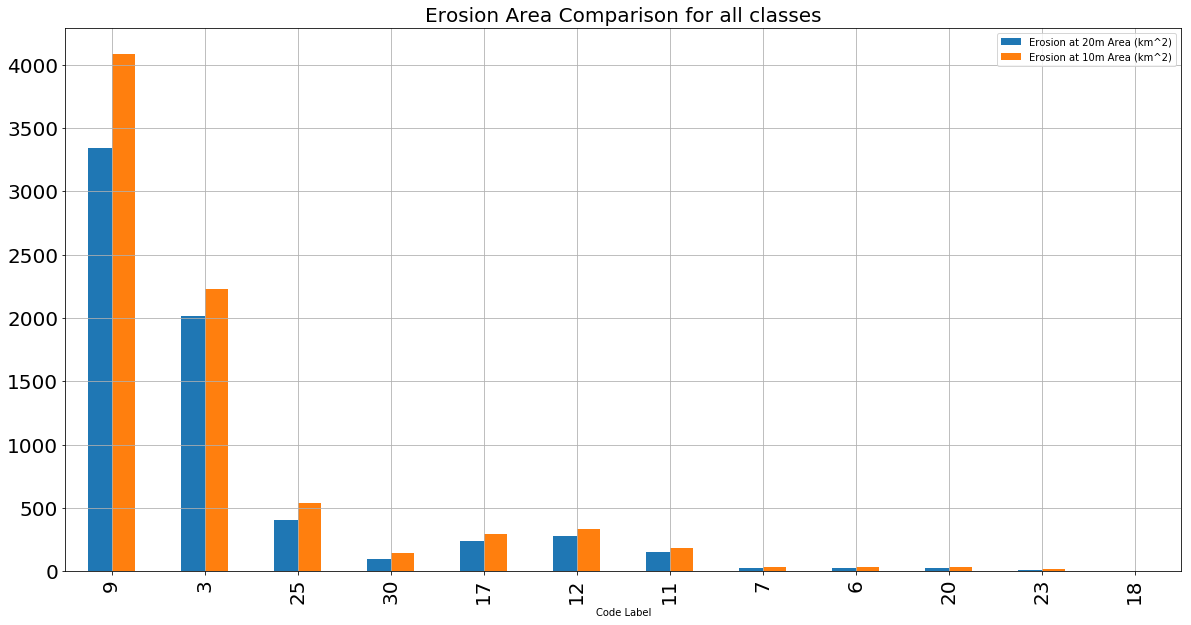

In [9]:
comparison[comparison.columns[-1::-2]].plot.bar(figsize=(20, 10),
                                                grid=True,
                                                fontsize=20)

title = 'Erosion Area Comparison for all classes'
plt.title(title, fontsize=20)
plt.savefig(Path(path['diag'], title + '.png'))

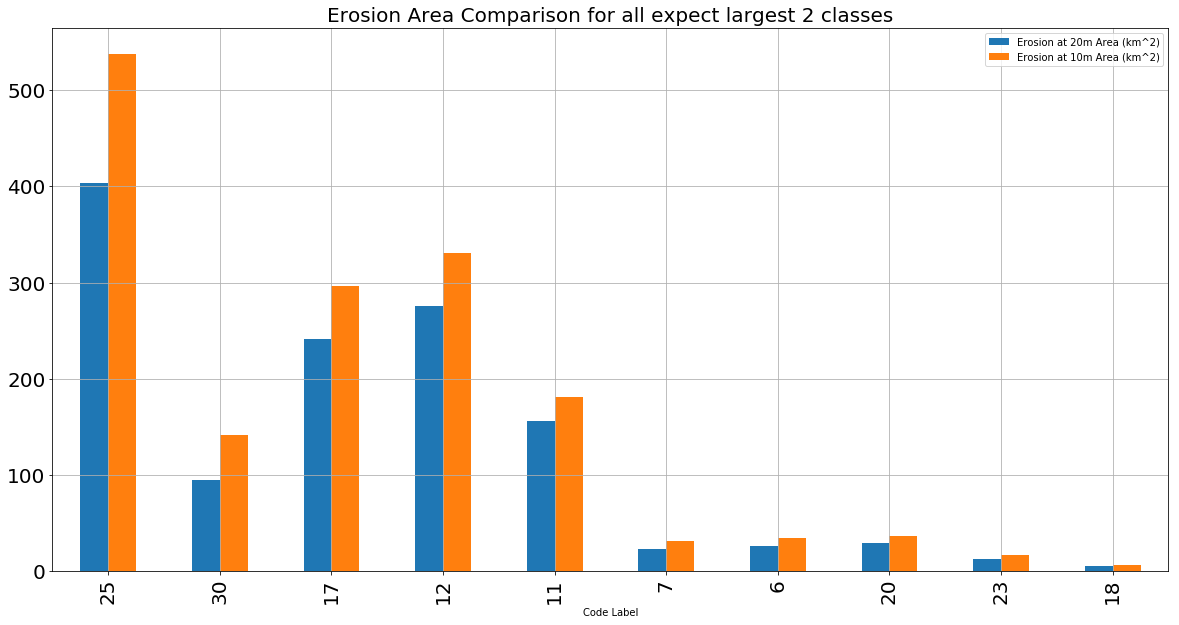

In [10]:
exceptclass = 2
comparison.iloc[exceptclass:][comparison.columns[-1::-2]].plot.bar(
    figsize=(20, 10), grid=True, fontsize=20)

title = f'Erosion Area Comparison for all expect largest {exceptclass} classes'
plt.title(title, fontsize=20)
plt.savefig(Path(path['diag'], title + '.png'))

#### Geometry Area Size Distribution

In [11]:
def describe_area_dist(i, merged, bins=20):
    plotdf = merged[[newclass]]
    plotdf['scaled_area'] = merged.geometry.area / geom_area_max_m2

    title = f'Area Size Distribution using Scaled Area at {i}m Erosion (bins={bins})'
    ax = plotdf['scaled_area'].plot.hist(bins=bins,
                                         grid=True,
                                         legend=True,
                                         figsize=(20, 10))
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Scaled Area', fontsize=20)
    ax.set_ylabel('Shape Frequency', fontsize=20)
    plt.savefig(join(path['diag'], title + '.png'))

    title = f'Area Size Distribution by Class using Scaled Area at {i}m Erosion (bins={bins})'
    plotdf.hist(by=newclass,
                column='scaled_area',
                bins=bins,
                grid=True,
                figsize=(20, 20))
    #     plt.title(title, fontsize=20)
    plt.savefig(join(path['diag'], title + '.png'))

    plotdf['area_m2'] = merged.geometry.area
    plotdf['area_km2'] = plotdf['area_m2'] / 10**6

    print(f'Description For {i}m Erosion')
    return plotdf.describe()

/home/tharen/miniconda3/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Description For 10m Erosion


code    scaled_area        area_m2       area_km2
count  105228.000000  105228.000000  105228.000000  105228.000000
mean       11.757289       0.301537   75384.198890       0.075384
std         7.984957       0.264308   66077.010956       0.066077
min         3.000000       0.010000    2500.002787       0.002500
25%         9.000000       0.077404   19350.942532       0.019351
50%         9.000000       0.215235   53808.730842       0.053809
75%        12.000000       0.452239  113059.738459       0.113060
max        30.000000       0.999988  249997.054139       0.249997

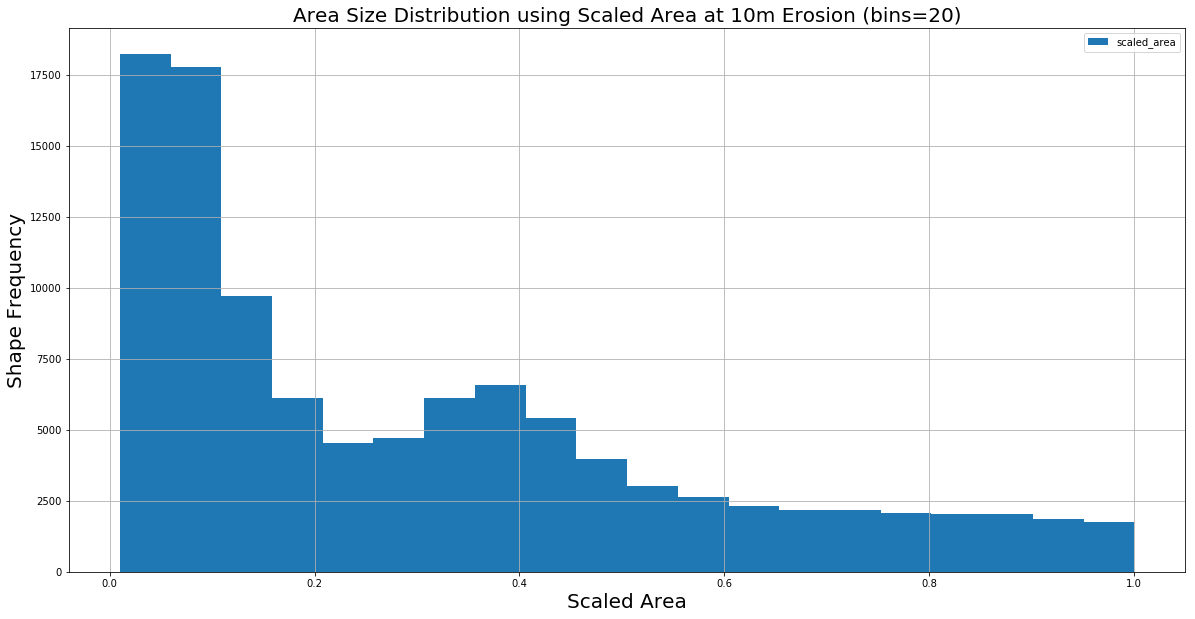

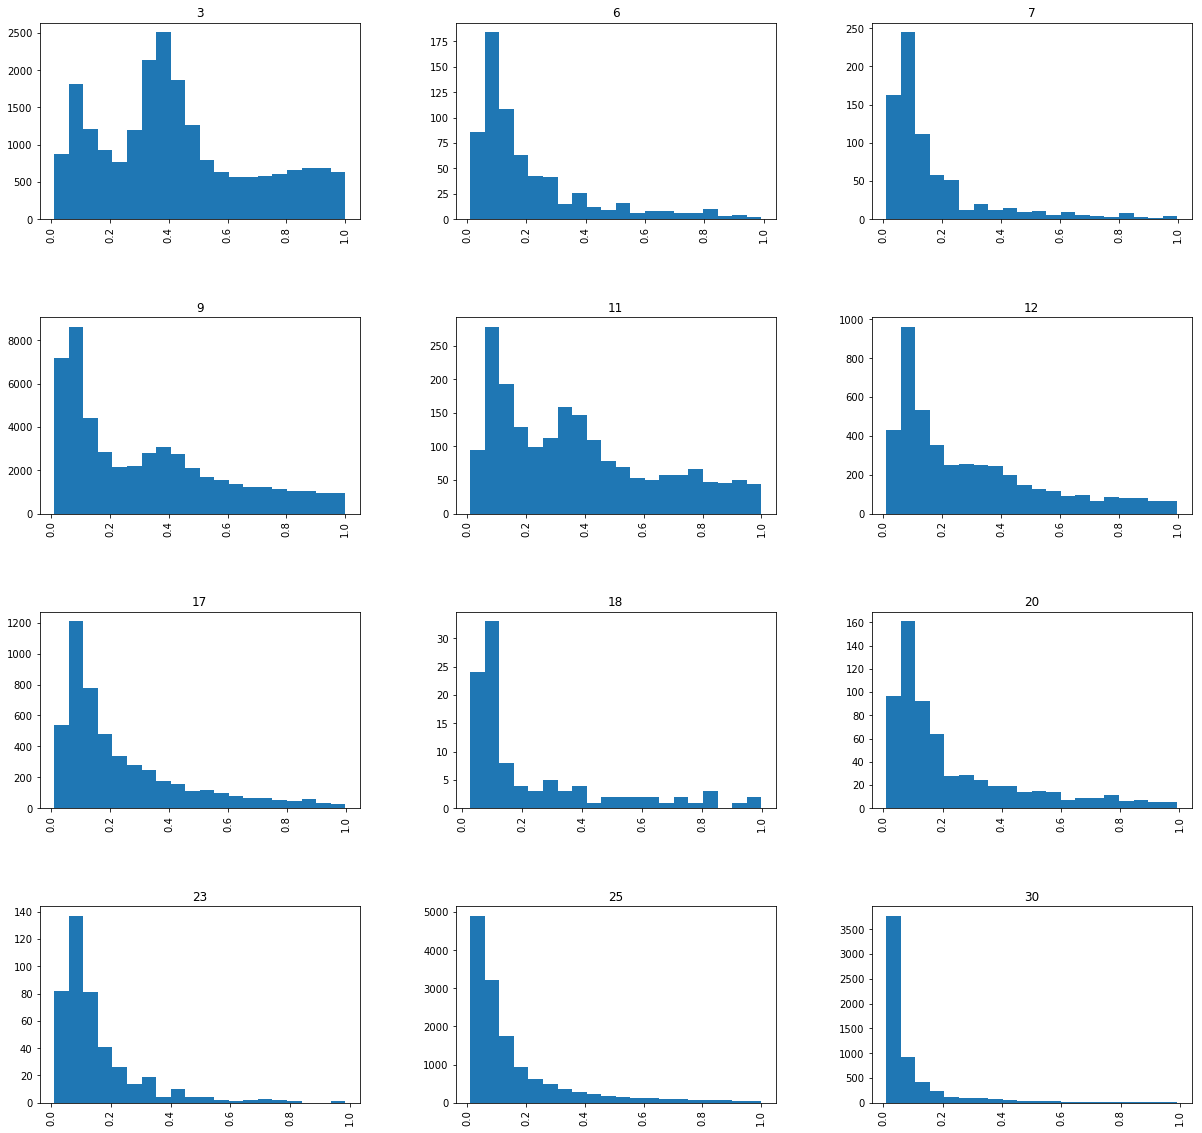

In [12]:
describe_area_dist(10, merged_10m)

/home/tharen/miniconda3/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Description For 20m Erosion


code    scaled_area        area_m2       area_km2
count  103557.000000  103557.000000  103557.000000  103557.000000
mean       11.315189       0.255859   63964.762580       0.063965
std         7.560384       0.261671   65417.711476       0.065418
min         3.000000       0.010001    2500.175799       0.002500
25%         9.000000       0.046646   11661.586811       0.011662
50%         9.000000       0.135721   33930.256935       0.033930
75%        12.000000       0.402813  100703.298280       0.100703
max        30.000000       0.999988  249996.960033       0.249997

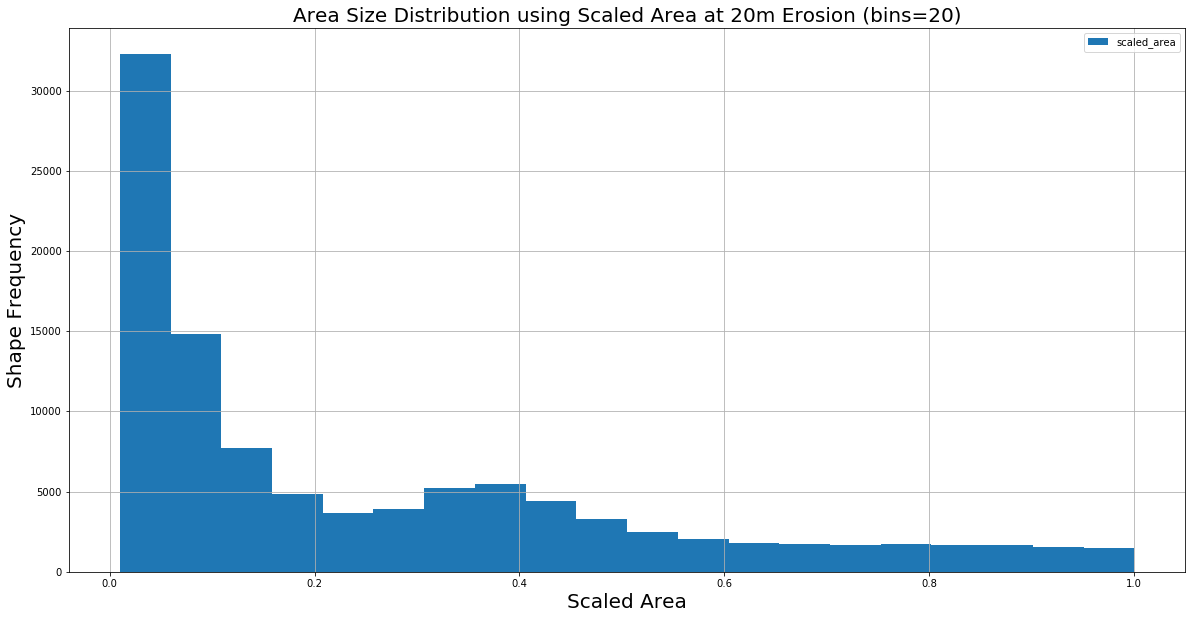

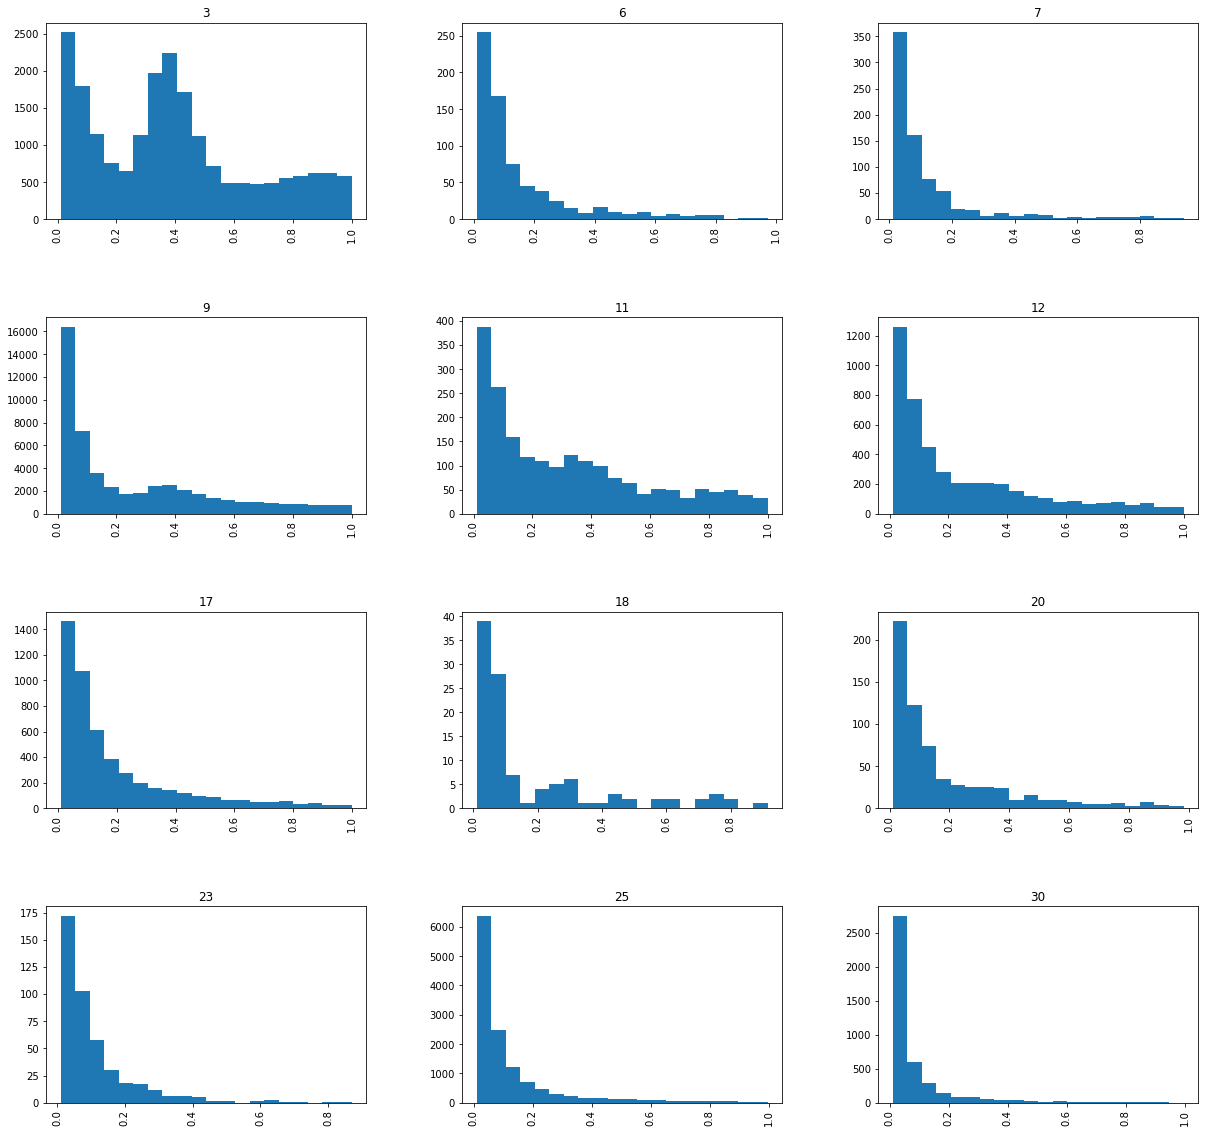

In [13]:
describe_area_dist(20, merged_20m)